# Estimacion de las frecuencias de corte de servicio
## Clustering

In [1]:
# Import the required packages
import os
import sys
in_colab = 'google.colab' in sys.modules

In [2]:
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/My Drive/Colab Notebooks/Data/"
else:
    BASE_DIR = "./Data/"

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.stats import stats

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from time import time
pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

### Extraer informacion de la base de datos y condensar en un solo dataframe

In [4]:
def prepare_data(Matriz):
    
    FIC = Matriz.FIC
    bin = np.array(FIC.values)
    FIC_bin = pd.cut(bin, bins=4, labels=False)
    
    X = Matriz.drop(['FIC'], axis=1)

    return X, FIC, FIC_bin

In [5]:
def purity_score(y_true, y_pred):

#    Args:
#        y_true(np.ndarray): n*1 matrix Ground truth labels
#        y_pred(np.ndarray): n*1 matrix Predicted clusters
#    
#    Returns:
#        float: Purity score
#    
#    References:
#        [1] https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html

    # matriz que mantiene la mayoria de labels votados
    
    y_voted_labels = np.zeros(y_true.shape)
    
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
        
    # Actualiza labels unicos
    
    labels = np.unique(y_true)
    
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner
    
    return accuracy_score(y_true, y_voted_labels)

In [6]:
# Adecuamos K-Means al dataset utilizando MiniBatchKmeans
def Calculo_MiniBatchKmeans(true_k, data):
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, random_state=0)
    y_kmeans = km.fit_predict(data)
    return km, y_kmeans

## Carga del dataset

In [7]:
dataset = BASE_DIR+'UNTRD_ENF.csv'

In [8]:
Data = pd.read_csv(dataset)
Data.set_index('COD_ID', drop=True, inplace=True)

In [9]:
Data.shape

(3305, 21)

In [10]:
Data

,DISTANCE_SUB,CTMT_PNTMT_STD,CLO_CEN,TIP_CC_RES-Tipo3,POT_NOM,PERD_A4_B,I_NOM_MED_R,CTMT_ENE_STD,CTMT_PNTMT_MED,UCBT_ENE_MED,...,CTMT_PNTBT_MAX,PAGE_RANK,TIP_TRAFO_M,FAS_CON_S_ABCN,CTMT_ENE_MED,GRU_TAR_B3,TIP_CC_RES-Tipo10,PERD_A4,TIP_CC_RES-Tipo5,FIC
COD_ID,,,,,,,,,,,,,,,,,,,,,
26879192,5104.49,2088.58,0.02,0.00,45.00,389840.98,365.00,43960.32,18885.60,2922.50,...,143337.13,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,0.00,1.00
26880293,3774.91,8194.44,0.01,0.00,112.50,408741.02,438.00,67863.54,22266.87,22227.00,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0.00
26880293,3774.91,8194.44,0.03,0.00,112.50,408741.02,438.00,67863.54,22266.87,22227.00,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0.00
26880295,3897.62,8194.44,0.01,0.00,75.00,408741.02,438.00,67863.54,22266.87,8893.00,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0.00
26880295,3897.62,8194.44,0.03,0.00,75.00,408741.02,438.00,67863.54,22266.87,8893.00,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26878633,15873.00,4838.27,0.00,0.00,30.00,379666.04,168.00,93329.28,13712.42,353.00,...,320696.78,0.00,0.00,1.00,1013653.45,0.00,0.00,198609.64,0.00,9.00
26878634,15732.31,4838.27,0.00,0.00,15.00,379666.04,168.00,93329.28,13712.42,190.00,...,320696.78,0.00,0.00,0.00,1013653.45,0.00,0.00,198609.64,0.00,16.00
26878635,16620.79,4838.27,0.00,0.00,10.00,379666.04,168.00,93329.28,13712.42,246.00,...,320696.78,0.00,1.00,0.00,1013653.45,0.00,0.00,198609.64,0.00,8.00


## Split Data

In [11]:
Data_X, Data_FIC, FIC_bin = prepare_data(Data)

In [12]:
# Se genera un dataset con los valores discretizados de FIC 
df_FIC_bin = pd.DataFrame({'FIC_bin': FIC_bin})

Data_X.reset_index(inplace=True)
Data_bin = pd.concat((Data_X, df_FIC_bin), axis=1)
Data_X.set_index('COD_ID', drop=True, inplace=True)
Data_bin.set_index('COD_ID', drop=True, inplace=True)
Data_bin.head(10)

,DISTANCE_SUB,CTMT_PNTMT_STD,CLO_CEN,TIP_CC_RES-Tipo3,POT_NOM,PERD_A4_B,I_NOM_MED_R,CTMT_ENE_STD,CTMT_PNTMT_MED,UCBT_ENE_MED,...,CTMT_PNTBT_MAX,PAGE_RANK,TIP_TRAFO_M,FAS_CON_S_ABCN,CTMT_ENE_MED,GRU_TAR_B3,TIP_CC_RES-Tipo10,PERD_A4,TIP_CC_RES-Tipo5,FIC_bin
COD_ID,,,,,,,,,,,,,,,,,,,,,
26879192,5104.49,2088.58,0.02,0.00,45.00,389840.98,365.00,43960.32,18885.60,2922.50,...,143337.13,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,0.00,0
26880293,3774.91,8194.44,0.01,0.00,112.50,408741.02,438.00,67863.54,22266.87,22227.00,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0
26880293,3774.91,8194.44,0.03,0.00,112.50,408741.02,438.00,67863.54,22266.87,22227.00,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0
26880295,3897.62,8194.44,0.01,0.00,75.00,408741.02,438.00,67863.54,22266.87,8893.00,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0
26880295,3897.62,8194.44,0.03,0.00,75.00,408741.02,438.00,67863.54,22266.87,8893.00,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0
26880297,3835.13,8194.44,0.03,0.00,112.50,408741.02,438.00,67863.54,22266.87,1080.50,...,119688.30,0.00,0.00,1.00,1648865.40,1.00,0.00,350609.30,0.00,0
26880298,4275.24,8194.44,0.01,0.00,75.00,408741.02,438.00,67863.54,22266.87,17356.50,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0
26880298,4275.24,8194.44,0.02,0.00,75.00,408741.02,438.00,67863.54,22266.87,17356.50,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0
26880299,4238.75,8194.44,0.03,0.00,112.50,408741.02,438.00,67863.54,22266.87,23069.50,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0


### Kmeans Clustering

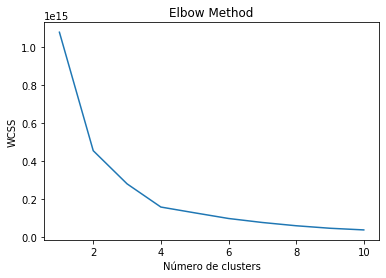

In [26]:
# Utilizamos el elbow method para encontrar el número óptimo de clusters con el dataset original con k-means

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter=100, random_state = 0) # n_jobs=-1
    km.fit(Data)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

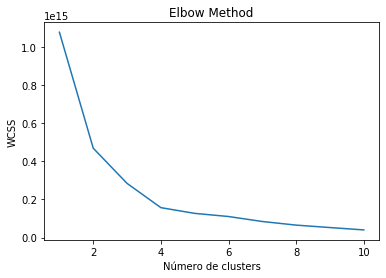

In [28]:
# Utilizamos el elbow method para encontrar el número óptimo de clusters con el dataset original con Mini Batch k-means

wcss = []
for i in range(1, 11):
    km = MiniBatchKMeans(n_clusters=i, init='k-means++', n_init=1,
         init_size=1000, batch_size=1000, random_state=0)
    km.fit(Data)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

In [33]:
labels = Data['FIC']
for c in range(2, 8):
    true_k = c
    km, y_kmeans = Calculo_MiniBatchKmeans(true_k, Data)
    print()
    print ('Calculo para ', c, ' Clusters')
    print()
    print("Clustering sparse data with %s" % km)
    t0 = time()
    km.fit(Data)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(labels, km.labels_))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(Data, km.labels_, sample_size=1000))
    print()
    print("Métrica de Pureza: %.3f" % purity_score(Data_FIC, y_kmeans))

    print()


Calculo para  2  Clusters

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=1, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)
done in 0.025s

Homogeneity: 0.013
Completeness: 0.044
V-measure: 0.020
Adjusted Rand-Index: -0.012
Silhouette Coefficient: 0.504

Métrica de Pureza: 0.345


Calculo para  3  Clusters

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=3, n_init=1, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)
done in 0.023s

Homogeneity: 0.042
Completeness: 0.097
V-measure: 0.059
Adjusted Rand-Index: 0.005
Silhouette Coefficient: 0.491

Métrica de Pureza: 0.345


Calculo para  4  Clusters

Clustering sparse data with Min

In [35]:
true_k = 4
km, y_kmeans = Calculo_MiniBatchKmeans(true_k, Data)

In [37]:
from sklearn.metrics.pairwise import pairwise_distances_argmin 
means_cluster_centers = np.sort(km.cluster_centers_, axis = 0) 
means_labels = pairwise_distances_argmin(Data, km.cluster_centers_) 

In [38]:
Data['Cluster']=means_labels

In [39]:
Data['Cluster'].value_counts().sort_index()

0     887
1     270
2     865
3    1283
Name: Cluster, dtype: int64

In [40]:
Data.shape

(3305, 22)

In [84]:
data_path = 'data\ENF_6612_2017-12-31_M10_20180820-1410.gdb'
DATA_CLUS0= Data['Cluster']data_dfo.reset_index(inplace=True)
UNTD_GEO = gpd.read_file(data_path, driver='FileGDB', layer= 'UNTRD')


In [105]:
DATA_CLUS=Data['Cluster'].to_frame().reset_index()


In [108]:
DATA_CLUS['COD_ID']=DATA_CLUS['COD_ID'].apply(str)
DATA_CLUS.dtypes

COD_ID     object
Cluster     int64
dtype: object

In [112]:
UNTD_GEO=UNTD_GEO.merge(DATA_CLUS, on='COD_ID', how='left')


In [113]:
Data_path = BASE_DIR+'UNTRD_Cluster.csv'
Data.to_csv(Data_path, index=False)

UNTD_GEO.to_file(driver = 'ESRI Shapefile', filename= BASE_DIR+"UNTD_CLUS.shp")

### Elementos mas cercanos al centroide

In [47]:
from scipy.spatial import cKDTree
kdtree = cKDTree(Data.iloc[:, 0:21]) 

In [48]:
distances, indices = kdtree.query(km.cluster_centers_, 100)
   

In [49]:
indices[0]

array([2824, 2579, 2825, 2826, 2820, 2581, 2583, 2822, 2578, 2828, 3161,
       2823, 3170, 2848, 2580, 2582, 2577, 2827, 2846, 3169, 2819, 3157,
       3159, 3171, 3160, 2586, 2817, 2984, 2833, 2844, 3145, 2584, 3162,
       3158, 3148, 2585, 3164, 3069, 3168, 2821, 3150, 2832, 2576, 2587,
       2590, 2845, 2830, 2840, 2843, 2588, 3142, 2842, 2816, 3147, 3167,
       3155, 2829, 2818, 2589, 2834, 2594, 2836, 2835, 3156, 2476, 3119,
       2839, 3154, 2592, 2603, 2841, 3117, 2831, 2591, 3153, 3141, 3140,
       3151, 2596, 2595, 2838, 2634, 2593, 3152, 2837, 3166, 3116, 3165,
       2350, 3163, 3065, 2609, 3149, 2349, 2635, 2636, 2597, 3113, 2640,
       2352])

In [66]:
elem_clus = pd.DataFrame([])
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    print()
    for ind in indices[i, :50]:
        elem_clus = elem_clus.append((pd.DataFrame(Data.iloc[ind]).transpose()))
    display (elem_clus)
    elem_clus = pd.DataFrame([])    

Cluster 0:


,DISTANCE_SUB,CTMT_PNTMT_STD,CLO_CEN,TIP_CC_RES-Tipo3,POT_NOM,PERD_A4_B,I_NOM_MED_R,CTMT_ENE_STD,CTMT_PNTMT_MED,UCBT_ENE_MED,...,PAGE_RANK,TIP_TRAFO_M,FAS_CON_S_ABCN,CTMT_ENE_MED,GRU_TAR_B3,TIP_CC_RES-Tipo10,PERD_A4,TIP_CC_RES-Tipo5,FIC,Cluster
26876780,16214.96,0.00,0.01,0.00,30.00,475052.12,438.00,21457.60,0.00,2401.50,...,0.00,0.00,1.00,459459.02,0.00,0.00,100388.53,0.00,6.00,0.00
26876823,16450.76,0.00,0.01,0.00,45.00,475052.12,438.00,21457.60,0.00,2514.50,...,0.00,0.00,0.00,459459.02,0.00,0.00,100388.53,0.00,2.00,0.00
26876782,16704.62,0.00,0.01,0.00,30.00,475052.12,438.00,21457.60,0.00,3694.50,...,0.00,0.00,0.00,459459.02,0.00,0.00,100388.53,0.00,6.00,0.00
26876783,16979.62,0.00,0.01,0.00,30.00,475052.12,438.00,21457.60,0.00,1220.00,...,0.00,0.00,1.00,459459.02,0.00,0.00,100388.53,1.00,10.00,0.00
26876773,13555.22,0.00,0.00,0.00,30.00,475052.12,438.00,21457.60,0.00,1871.50,...,0.00,0.00,0.00,459459.02,0.00,0.00,100388.53,0.00,14.00,0.00
26876825,16259.99,0.00,0.00,0.00,15.00,475052.12,438.00,21457.60,0.00,634.00,...,0.00,0.00,0.00,459459.02,0.00,0.00,100388.53,0.00,12.00,0.00
26876827,16758.48,0.00,0.01,0.00,25.00,475052.12,438.00,21457.60,0.00,857.50,...,0.00,1.00,0.00,459459.02,0.00,1.00,100388.53,0.00,12.00,0.00
26876776,15172.63,0.00,0.00,0.00,15.00,475052.12,438.00,21457.60,0.00,375.50,...,0.00,0.00,1.00,459459.02,0.00,0.00,100388.53,0.00,6.00,0.00
26876821,14406.70,0.00,0.00,0.00,15.00,475052.12,438.00,21457.60,0.00,559.50,...,0.00,0.00,0.00,459459.02,0.00,0.00,100388.53,0.00,6.00,0.00
26876786,16019.06,0.00,0.00,1.00,10.00,475052.12,438.00,21457.60,0.00,313.00,...,0.00,1.00,0.00,459459.02,0.00,0.00,100388.53,0.00,10.00,0.00


Cluster 1:


,DISTANCE_SUB,CTMT_PNTMT_STD,CLO_CEN,TIP_CC_RES-Tipo3,POT_NOM,PERD_A4_B,I_NOM_MED_R,CTMT_ENE_STD,CTMT_PNTMT_MED,UCBT_ENE_MED,...,PAGE_RANK,TIP_TRAFO_M,FAS_CON_S_ABCN,CTMT_ENE_MED,GRU_TAR_B3,TIP_CC_RES-Tipo10,PERD_A4,TIP_CC_RES-Tipo5,FIC,Cluster
79761050,4808.40,15779.90,0.01,0.00,75.00,605749.12,438.00,141887.74,62636.97,6778.50,...,0.00,0.00,0.00,2276963.08,0.00,0.00,585114.24,0.00,2.00,1.00
26877318,4973.35,15779.90,0.01,0.00,45.00,605749.12,438.00,141887.74,62636.97,6194.00,...,0.00,0.00,0.00,2276963.08,0.00,0.00,585114.24,0.00,6.00,1.00
26877308,4339.07,15779.90,0.01,0.00,45.00,605749.12,438.00,141887.74,62636.97,7837.00,...,0.00,0.00,0.00,2276963.08,0.00,0.00,585114.24,0.00,2.00,1.00
26877322,5275.55,15779.90,0.01,0.00,45.00,605749.12,438.00,141887.74,62636.97,8301.00,...,0.00,0.00,0.00,2276963.08,0.00,0.00,585114.24,0.00,6.00,1.00
26877388,6360.07,15779.90,0.01,0.00,45.00,605749.12,230.00,141887.74,62636.97,7480.50,...,0.00,0.00,0.00,2276963.08,0.00,0.00,585114.24,0.00,6.00,1.00
26877267,4608.06,15779.90,0.01,0.00,75.00,605749.12,438.00,141887.74,62636.97,8245.00,...,0.00,0.00,0.00,2276963.08,0.00,0.00,585114.24,0.00,2.00,1.00
26877307,3973.30,15779.90,0.01,0.00,75.00,605749.12,438.00,141887.74,62636.97,7369.50,...,0.00,0.00,0.00,2276963.08,0.00,0.00,585114.24,0.00,2.00,1.00
26877389,6492.29,15779.90,0.01,0.00,45.00,605749.12,230.00,141887.74,62636.97,6861.50,...,0.00,0.00,0.00,2276963.08,0.00,0.00,585114.24,0.00,6.00,1.00
26877333,6061.37,15779.90,0.01,0.00,75.00,605749.12,168.00,141887.74,62636.97,8277.50,...,0.00,0.00,0.00,2276963.08,0.00,0.00,585114.24,0.00,6.00,1.00
26877263,3945.52,15779.90,0.01,0.00,45.00,605749.12,438.00,141887.74,62636.97,7776.50,...,0.00,0.00,0.00,2276963.08,0.00,0.00,585114.24,0.00,2.00,1.00


Cluster 2:


,DISTANCE_SUB,CTMT_PNTMT_STD,CLO_CEN,TIP_CC_RES-Tipo3,POT_NOM,PERD_A4_B,I_NOM_MED_R,CTMT_ENE_STD,CTMT_PNTMT_MED,UCBT_ENE_MED,...,PAGE_RANK,TIP_TRAFO_M,FAS_CON_S_ABCN,CTMT_ENE_MED,GRU_TAR_B3,TIP_CC_RES-Tipo10,PERD_A4,TIP_CC_RES-Tipo5,FIC,Cluster
26879246,6586.65,2088.58,0.01,0.00,112.50,389840.98,365.00,43960.32,18885.60,7237.50,...,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,0.00,0.00,2.00
26879229,5968.43,2088.58,0.02,0.00,45.00,389840.98,365.00,43960.32,18885.60,7795.50,...,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,0.00,14.00,2.00
26879191,5813.85,2088.58,0.02,0.00,112.50,389840.98,365.00,43960.32,18885.60,9377.50,...,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,0.00,14.00,2.00
26879247,6832.07,2088.58,0.01,0.00,75.00,389840.98,365.00,43960.32,18885.60,10846.00,...,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,0.00,0.00,2.00
26879216,5359.71,2088.58,0.02,0.00,75.00,389840.98,365.00,43960.32,18885.60,9323.00,...,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,0.00,14.00,2.00
26879223,5692.10,2088.58,0.02,0.00,75.00,389840.98,365.00,43960.32,18885.60,11306.50,...,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,0.00,0.00,2.00
26879181,4277.49,2088.58,0.02,0.00,75.00,389840.98,365.00,43960.32,18885.60,8050.50,...,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,1.00,14.00,2.00
26879193,5866.00,2088.58,0.02,0.00,75.00,389840.98,365.00,43960.32,18885.60,5144.50,...,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,0.00,14.00,2.00
26879248,6273.53,2088.58,0.02,0.00,75.00,389840.98,365.00,43960.32,18885.60,4895.50,...,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,0.00,14.00,2.00
26879214,4164.33,2088.58,0.02,0.00,75.00,389840.98,365.00,43960.32,18885.60,6924.50,...,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,1.00,6.00,2.00


Cluster 3:


,DISTANCE_SUB,CTMT_PNTMT_STD,CLO_CEN,TIP_CC_RES-Tipo3,POT_NOM,PERD_A4_B,I_NOM_MED_R,CTMT_ENE_STD,CTMT_PNTMT_MED,UCBT_ENE_MED,...,PAGE_RANK,TIP_TRAFO_M,FAS_CON_S_ABCN,CTMT_ENE_MED,GRU_TAR_B3,TIP_CC_RES-Tipo10,PERD_A4,TIP_CC_RES-Tipo5,FIC,Cluster
26876337,10536.27,236.63,0.01,0.00,45.00,506374.22,438.00,49923.49,909.23,5945.50,...,0.00,0.00,0.00,844268.40,0.00,0.00,180278.34,1.00,12.00,3.00
26876345,11037.20,236.63,0.01,0.00,45.00,506374.22,438.00,49923.49,909.23,6208.50,...,0.00,0.00,0.00,844268.40,0.00,0.00,180278.34,1.00,10.00,3.00
26876322,9583.59,236.63,0.01,0.00,30.00,506374.22,438.00,49923.49,909.23,5791.50,...,0.00,0.00,0.00,844268.40,0.00,0.00,180278.34,0.00,6.00,3.00
26876325,9620.73,236.63,0.01,1.00,30.00,506374.22,438.00,49923.49,909.23,5498.50,...,0.00,0.00,0.00,844268.40,0.00,0.00,180278.34,0.00,18.00,3.00
26876320,9422.00,236.63,0.01,0.00,45.00,506374.22,438.00,49923.49,909.23,6799.00,...,0.00,0.00,0.00,844268.40,0.00,0.00,180278.34,1.00,14.00,3.00
26876342,10910.11,236.63,0.01,0.00,45.00,506374.22,438.00,49923.49,909.23,4111.50,...,0.00,0.00,0.00,844268.40,0.00,0.00,180278.34,0.00,6.00,3.00
26876353,12138.64,236.63,0.01,0.00,45.00,506374.22,438.00,49923.49,909.23,7097.00,...,0.00,0.00,0.00,844268.40,0.00,0.00,180278.34,1.00,4.00,3.00
26876347,11234.99,236.63,0.01,0.00,45.00,506374.22,438.00,49923.49,909.23,7941.00,...,0.00,0.00,0.00,844268.40,0.00,0.00,180278.34,0.00,18.00,3.00
26876365,13064.00,236.63,0.01,0.00,45.00,506374.22,438.00,49923.49,909.23,4599.00,...,0.00,0.00,0.00,844268.40,0.00,0.00,180278.34,1.00,18.00,3.00
26876330,10043.28,236.63,0.01,0.00,45.00,506374.22,438.00,49923.49,909.23,2867.50,...,0.00,0.00,0.00,844268.40,0.00,0.00,180278.34,0.00,6.00,3.00


### Reduccion de Dimensionalidad con PCA

In [67]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(Data_X)
dfx = pd.DataFrame(data=X_train,columns=Data_X.columns[0:])
dfx.head(5)

,DISTANCE_SUB,CTMT_PNTMT_STD,CLO_CEN,TIP_CC_RES-Tipo3,POT_NOM,PERD_A4_B,I_NOM_MED_R,CTMT_ENE_STD,CTMT_PNTMT_MED,UCBT_ENE_MED,I_NOM_MIN_R,CTMT_PNTBT_MAX,PAGE_RANK,TIP_TRAFO_M,FAS_CON_S_ABCN,CTMT_ENE_MED,GRU_TAR_B3,TIP_CC_RES-Tipo10,PERD_A4,TIP_CC_RES-Tipo5
0,-0.63,-0.54,0.45,-0.28,-0.14,-0.16,-0.03,-0.46,0.40,-0.15,0.78,0.45,-0.01,-0.53,-0.38,0.79,-0.28,-0.23,0.26,-0.34
1,-0.78,0.16,0.18,-0.28,1.17,-0.02,0.76,0.27,0.48,0.79,0.18,0.20,0.03,-0.53,-0.38,1.23,-0.28,-0.23,0.86,-0.34
2,-0.78,0.16,1.68,-0.28,1.17,-0.02,0.76,0.27,0.48,0.79,0.18,0.20,0.64,-0.53,-0.38,1.23,-0.28,-0.23,0.86,-0.34
3,-0.77,0.16,0.19,-0.28,0.44,-0.02,0.76,0.27,0.48,0.14,0.18,0.20,0.03,-0.53,-0.38,1.23,-0.28,-0.23,0.86,-0.34
4,-0.77,0.16,1.68,-0.28,0.44,-0.02,0.76,0.27,0.48,0.14,0.18,0.20,0.66,-0.53,-0.38,1.23,-0.28,-0.23,0.86,-0.34


In [68]:
# Aplicamos PCA
pca = PCA(n_components = None , random_state=0)
dfx_pca = pca.fit(dfx)
explained_variance = dfx_pca.explained_variance_ratio_

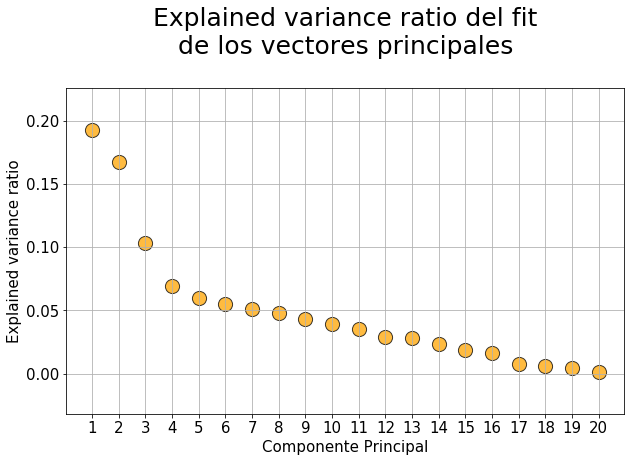

In [69]:
#Graficamos los porcentajes de la varianza de las variables generadas
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(explained_variance))],
            y=dfx_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio del fit\nde los vectores principales\n",fontsize=25)
plt.xlabel("Componente Principal",fontsize=15)
plt.xticks([i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [70]:
print('La suma de los cuatro primeros componentes nos da ',sum(explained_variance[0:4]))
print("lo que abarca mas de la mitad de la variaza por lo que tomaremos estos cuatro valores" )

La suma de los cuatro primeros componentes nos da  0.5325892306655606
lo que abarca mas de la mitad de la variaza por lo que tomaremos estos cuatro valores


In [71]:
dfx_trans = pca.transform(dfx)

In [72]:
dfx_trans = pd.DataFrame(data=dfx_trans)
dfx_trans.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.64,0.46,-0.64,0.11,0.26,-0.21,0.04,-0.26,-0.47,0.67,-0.02,-0.07,0.89,-0.55,-0.25,-0.06,-0.55,-0.23,-0.25,-0.34
1,1.10,1.63,-0.18,0.13,0.72,1.03,-0.11,0.16,-0.16,0.38,-0.38,0.06,0.52,0.28,-0.46,0.28,-0.15,0.09,-0.16,-0.31
2,1.99,1.47,-0.15,0.37,0.79,0.85,-0.43,-0.26,0.23,-0.10,-0.74,-0.26,0.87,0.19,-0.15,-0.01,-0.44,-0.34,-0.40,0.12
3,0.77,1.53,-0.15,0.09,0.60,0.52,-0.18,-0.26,-0.52,0.33,-0.33,-0.26,0.40,-0.04,-0.41,0.24,-0.20,0.04,-0.17,-0.34
4,1.66,1.37,-0.13,0.33,0.67,0.33,-0.50,-0.68,-0.13,-0.15,-0.69,-0.58,0.76,-0.14,-0.09,-0.04,-0.48,-0.38,-0.41,0.08


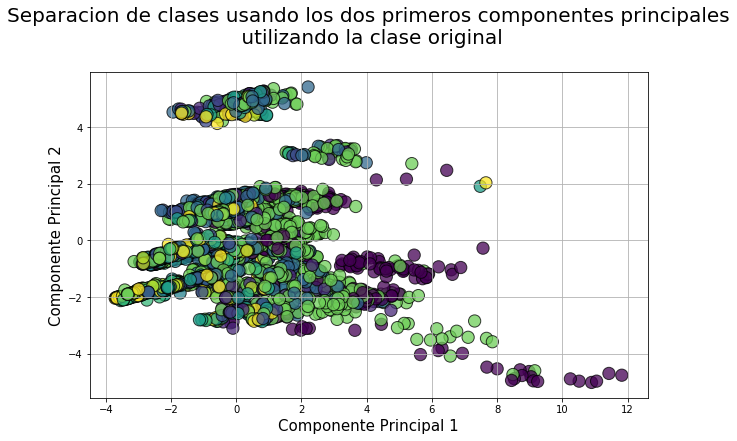

In [73]:
plt.figure(figsize=(10,6))
plt.scatter(dfx_trans[0], dfx_trans[1], c=Data_FIC, edgecolors='k', alpha=0.75, s=150)
plt.grid(True)
plt.title("Separacion de clases usando los dos primeros componentes principales\n utilizando la clase original\n",fontsize=20)
plt.xlabel("Componente Principal 1",fontsize=15)
plt.ylabel("Componente Principal 2",fontsize=15)
plt.show()

In [74]:
# Aplicamos PCA con los tres componentes principales seleccionados
pca = PCA(n_components = 4 , random_state=0)
dfx_pca = pca.fit(dfx)
X_train = pca.fit_transform(dfx)
explained_variance = dfx_pca.explained_variance_ratio_
explained_variance

array([0.19263033, 0.16716397, 0.1036861 , 0.06910769])

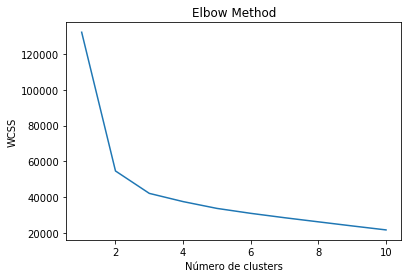

In [75]:
# Utilizamos el elbow method para encontrar el número óptimo de clusters con las variables reducidas por PCA
Data_pca = np.insert(X_train, 2, Data_FIC, axis=1)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(Data_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

In [23]:
# Calculamos K-means con las variables reducidas por PCA
labels = Data['FIC']
for c in range(2, 8):
    true_k = c
    km, y_kmeans = Calculo_MiniBatchKmeans(true_k, Data_pca)
    print()
    print ('Calculo para ', c, ' Clusters')
    print()
    print("Clustering sparse data with %s" % km)
    t0 = time()
    km.fit(Data)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(labels, km.labels_))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(Data, km.labels_, sample_size=1000))
    print()
    print("Métrica de Pureza: %.3f" % purity_score(Data_FIC, y_kmeans))

    print()


Calculo para  2  Clusters

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=1, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)
done in 0.025s

Homogeneity: 0.019
Completeness: 0.093
V-measure: 0.032
Adjusted Rand-Index: -0.001
Silhouette Coefficient: 0.505

Métrica de Pureza: 0.000


Calculo para  3  Clusters

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=3, n_init=1, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)
done in 0.037s

Homogeneity: 0.042
Completeness: 0.097
V-measure: 0.059
Adjusted Rand-Index: 0.005
Silhouette Coefficient: 0.474

Métrica de Pureza: 0.357


Calculo para  4  Clusters

Clustering sparse data with Min

In [24]:
true_k = 7
km, y_kmeans = Calculo_MiniBatchKmeans(true_k, Data_pca)

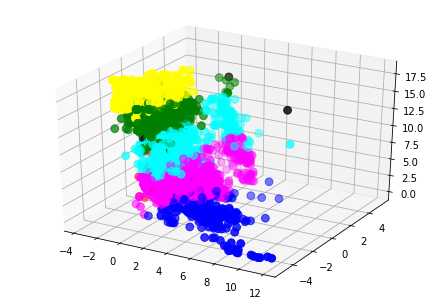

In [25]:
# Visualización  de clusters

# Predicting the clusters
labels = y_kmeans
# Getting the cluster centers
C = km.cluster_centers_
colores=['red','green','blue','cyan','yellow', 'magenta', 'black']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Data_pca[:, 0], Data_pca[:, 1], Data_pca[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
